Lateness Report [link](https://gttwiki.atlassian.net/wiki/spaces/GD/pages/2492956684/Lateness+report)

Approach 2 (compare time late for the last stop for TSPon vs TSPoff)

In [1]:
import pandas as pd
import os
from data_preparation import prepare_triplogs, prepare_tripdatas, get_clean_triplogs, get_clean_tripdatas

In [2]:
data_dir = "../2020_11_8_to_2020_11_14"

In [3]:
!ls ../2020_11_8_to_2020_11_14/CMS

intersectionstatusreport.csv
intersectionstatusreport_data_dictionary.docx
opticomdevicelog.csv
opticomdevicelog_data_dictonary.docx


In [4]:
tripdatas_df = pd.read_csv(os.path.join(data_dir, "CVP/tripdatas.csv"))

In [5]:
triplogs_df = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

In [6]:
opticomdevicelog_df = pd.read_csv(os.path.join(data_dir, "CMS/opticomdevicelog.csv"))

In [7]:
triplogs_df = prepare_triplogs(triplogs_df)
tripdatas_df = prepare_tripdatas(tripdatas_df)

# takes about 10 minutes to run

tripdatas_df = get_clean_tripdatas(tripdatas_df) # cleaning tripdatas first is important
tripdatas_df_good = tripdatas_df[tripdatas_df["is_good_for_study"]]
triplogs_df = get_clean_triplogs(triplogs_df, tripdatas_df_good)
triplogs_df_good = triplogs_df[triplogs_df["is_good_for_study"]]

drop invalid
drop starttime >= endtime
drop endstatus not completed
drop normal tspmode
drop negative duration
drop <=70% stops hit
drop <=70% breadcrumbs
drop duplicated rows
drop tspon no tsp requests
drop 3 stds anomalies


In [8]:
from collections import defaultdict

def get_uid_to_curbreadcrumbs(tripdatas_df_good):
    uid_to_curbreadcrumbs = defaultdict(list)
    for ind, row in tripdatas_df_good[tripdatas_df_good["event"] == 'stop arrive'].iterrows():
        uid_to_curbreadcrumbs[row["uid"]].append(row)

    for k in uid_to_curbreadcrumbs.keys():
        uid_to_curbreadcrumbs[k] = pd.DataFrame(uid_to_curbreadcrumbs[k])
    return uid_to_curbreadcrumbs
        


In [9]:
uid_to_curbreadcrumbs = get_uid_to_curbreadcrumbs(tripdatas_df_good)

In [10]:
import datetime

def get_last_stop_trackTime(triplog_uid, triplog_endtime, uid_to_curbreadcrumbs):
    """
    triplog_uid - uid from triplogs
    triplog_endtime - endtime from row in triplogs (for this route + direction)
    it is required because there is no clear way to match route + direction to same breadcrumbs in tripdatas
    We do it by finding stop arrive event in tripdatas for given uid that is closest by time to endtime in triplogs
    but it must happen before the endtime in triplogs. From that row we take tracktime.
    
    returns track time of last stop hit in this route + direction
    triplog_endtime
    """
    cur_breadcrumbs = uid_to_curbreadcrumbs[triplog_uid]
    
    cur_breadcrumbs.loc[:,"endtime_delta"] = cur_breadcrumbs["time"] - triplog_endtime
    cur_breadcrumbs = cur_breadcrumbs[cur_breadcrumbs["endtime_delta"] < datetime.timedelta(0)]
    row_with_min_delta = cur_breadcrumbs.sort_values("endtime_delta", ascending=False).iloc[0]
    
    return row_with_min_delta['tracktime']

In [11]:
#2mins
triplogs_df_good["last_stop_tracktime"] = triplogs_df_good.apply(lambda row: get_last_stop_trackTime(row["uid"], row["endtime"], uid_to_curbreadcrumbs) , axis = 1)

<ipython-input-11-cf837eabbacb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplogs_df_good["last_stop_tracktime"] = triplogs_df_good.apply(lambda row: get_last_stop_trackTime(row["uid"], row["endtime"], uid_to_curbreadcrumbs) , axis = 1)


In [12]:
triplogs_df_good["last_stop_tracktime"].head()

1      1.0
3     -4.0
4    -20.0
5      9.0
14     5.0
Name: last_stop_tracktime, dtype: float64

In [13]:
import numpy as np
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction', 'stops'])['last_stop_tracktime'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [14]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction', 'stops'])['last_stop_tracktime'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [15]:
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]


print(triplogs_on.shape)

(78,)
(52,)


In [16]:
from scipy import stats
# mann-whitney u-test
def mannwhitney(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:
            try:
                pval = stats.mannwhitneyu(triplogs_on[idx], triplogs_off[idx], alternative='greater').pvalue
                if pval < 0.05:
                    pass
                    #print(idx, f'route is significally faster with pval {pval:.2f}')
                rejected.append(
                    (pval, idx)
                )
            except ValueError:
                num_errors += 1
            
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [17]:
# student two samples t-test
def student(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:   
            pval = stats.ttest_ind(triplogs_on[idx], triplogs_off[idx], alternative='greater').pvalue
            if pval < 0.05:
                # check same variance assumption (timings of two type of routes must have variance close to each other)
                s1 = np.sqrt(np.var(triplogs_on[idx], ddof=1))
                s2 = np.sqrt(np.var(triplogs_off[idx], ddof=1))
                valid = 'test valid'
                if np.abs(s1 - s2) > 3:
                    num_errors += 1
                else:
                    rejected.append(
                        (pval, idx)
                    )
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [18]:
def plot_trips(triplogs_on, triplogs_off, rejected_idxs):
    fig, ax = plt.subplots(len(rejected_idxs), 1,figsize=(15,15), constrained_layout=True)
    for i, (pval, idx)  in enumerate(rejected_idxs):
        title = f'{", ".join(map(str, idx))}, pval {pval:.2f}'
        ax[i].set_title(title)
        ax[i].plot(triplogs_on[idx], label='on')
        ax[i].plot(triplogs_off[idx], label='off')
        ax[i].legend()

In [19]:
def make_df(rejected_idxs, groupby):
    df = [list(x)+[pval] for pval,x in rejected_idxs]
    df = pd.DataFrame(df)
    df.columns = groupby + ['pval']
    df = df.sort_values('pval')
    return df.reset_index(drop=True)

In [20]:
triplogs_on.head()

routename  direction  stops
1          inbound    21                      [4.0, 9.0, 12.0, 11.0, 14.0, 16.0]
                      48       [1.0, 5.0, -2.0, 5.0, -6.0, -9.0, -9.0, -8.0, ...
           outbound   28                             [17.0, 20.0, 7.0, 0.0, 6.0]
                      48       [6.0, -2.0, -6.0, 0.0, 5.0, 2.0, 1.0, 1.0, 0.0...
12         outbound   19       [-2.0, -4.0, -2.0, 1.0, 6.0, 4.0, 1.0, 2.0, 2....
Name: last_stop_tracktime, dtype: object

48 of 52 rejected 0.9230769230769231
number of errors: 0


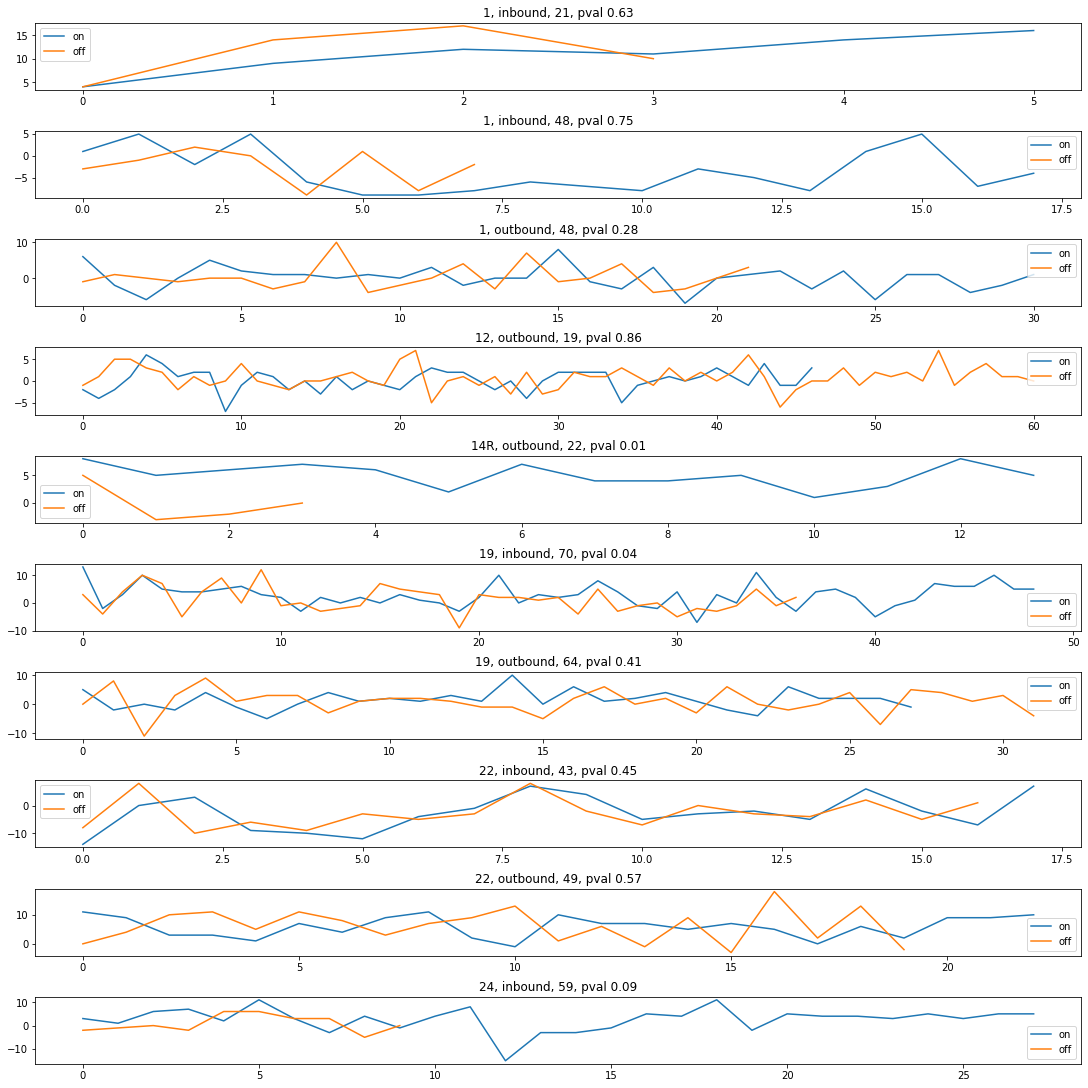

In [21]:
import matplotlib.pyplot as plt
rejected_idxs_manw, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_manw[:10])

6 of 52 rejected 0.11538461538461539
number of errors: 1


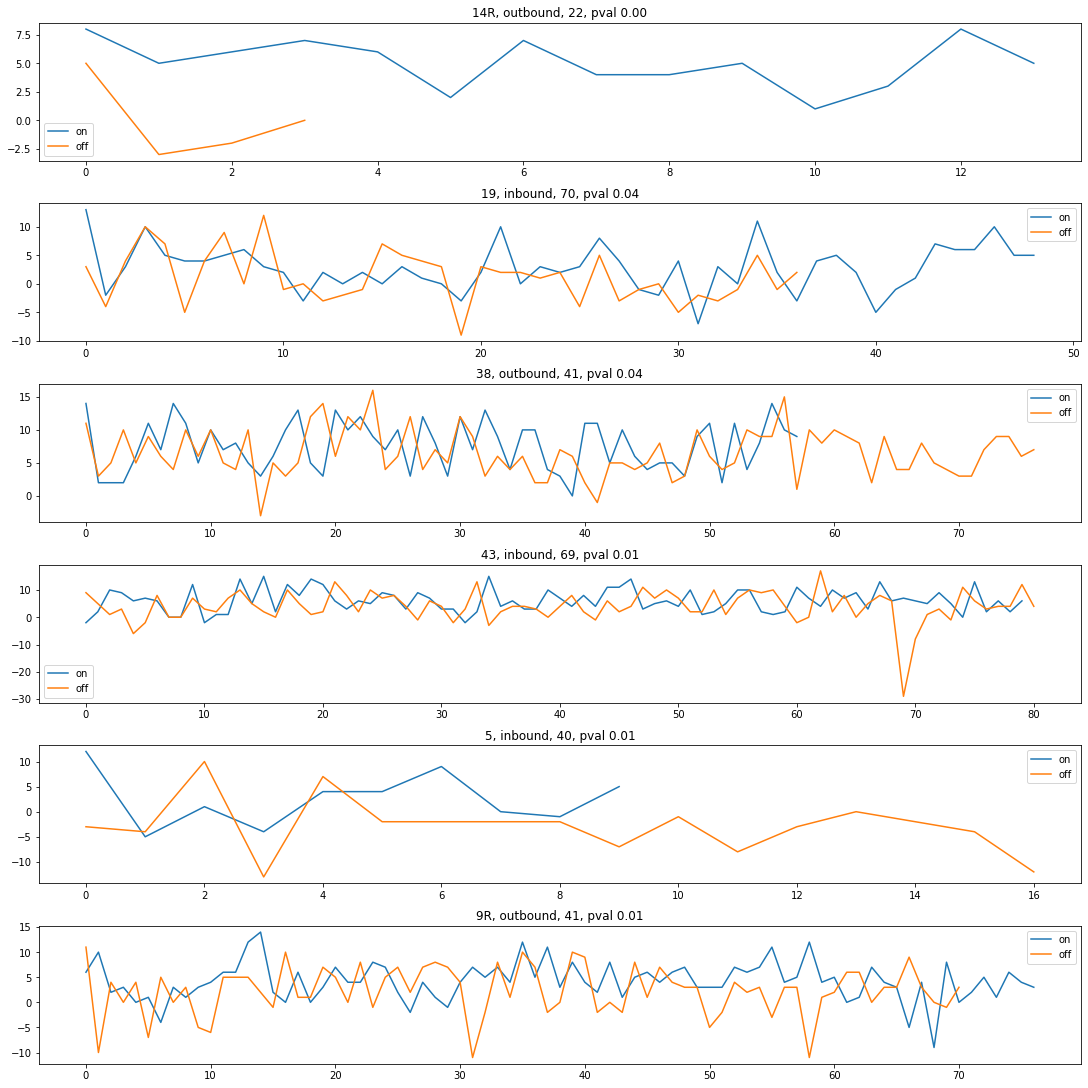

In [22]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_stud[:10])

In [23]:
rejected_idxs_manw_new = [x[1] for x in rejected_idxs_manw]
rejected_idxs_stud_new = [x[1] for x in rejected_idxs_stud]
len(set(rejected_idxs_manw_new).intersection(rejected_idxs_stud_new))

6

## Hourly separation

In [24]:
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction','stops', "starthour"])['last_stop_tracktime'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [25]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction','stops', "starthour"])['countlate'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [26]:
# drop less that 3 obserations
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]
print(triplogs_on.shape)

(445,)
(257,)


188 of 257 rejected 0.7315175097276264
number of errors 0


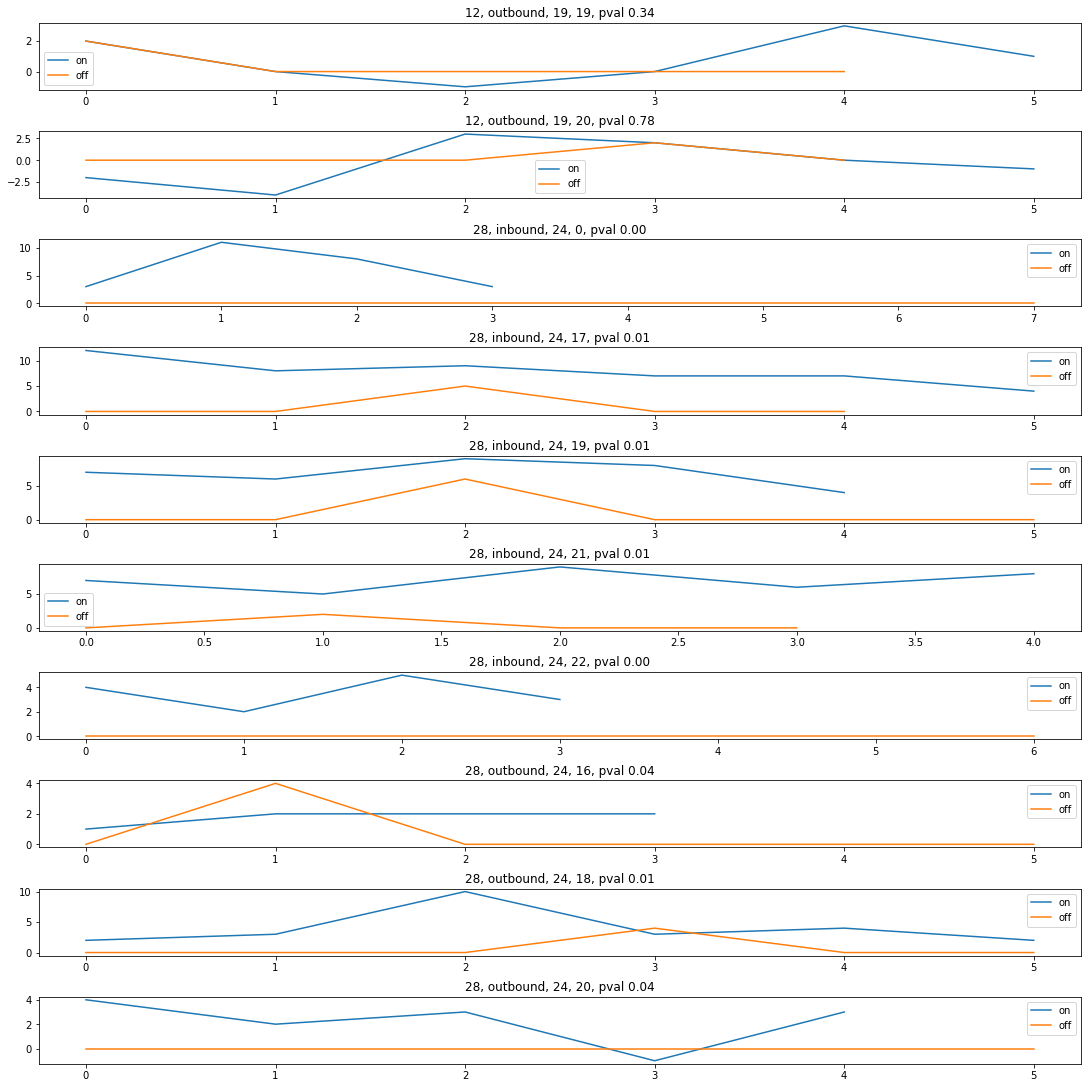

In [27]:
rejected_idxs_man, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_man[:10])

51 of 257 rejected 0.19844357976653695
number of errors 45


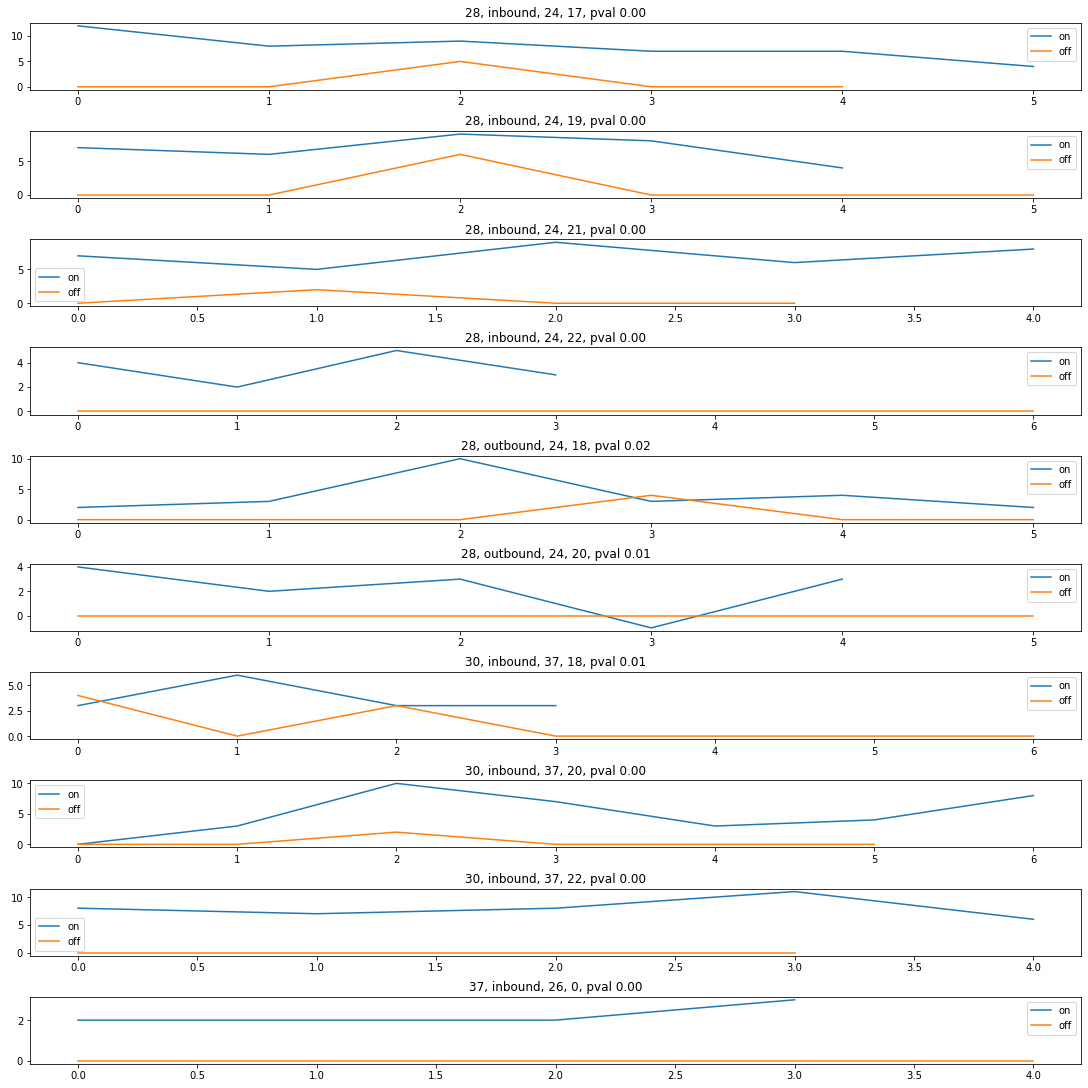

In [28]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_stud[:10])